In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import hddm 
from patsy import dmatrix 
import numpy as np
# print(hddm.__version__)

%matplotlib inline

/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Pre-processing

In [2]:
!pwd

/Users/Krista/Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis


In [3]:
all_data = hddm.load_csv('aggregated_data/cleaned_probC_data_test.csv')

In [4]:
all_data.head(10)

Unnamed: 0  choice  accuracy  solution  reward  cumulative_reward  \
0           0     1.0       1.0       1.0     1.0              600.0   
1           1     0.0       0.0       1.0     0.0              599.0   
2           2     1.0       0.0       0.0     0.0              598.0   
3           3     1.0       1.0       1.0     3.0              600.0   
4           4     0.0       1.0       0.0     3.0              602.0   
5           5     1.0       1.0       1.0     2.0              603.0   
6           6     0.0       0.0       1.0     0.0              602.0   
7           7     1.0       0.0       0.0     0.0              601.0   
8           8     0.0       0.0       1.0     0.0              600.0   
9           9     1.0       0.0       0.0     0.0              599.0   

         rt  total_trial_time       iti  cp_with_slow_fast  \
0  0.525745          2.060731  0.545611                0.0   
1  0.296897          1.812463  0.524884                0.0   
2  0.210249          1.496023  0.304553                0.0   
3  0.276397          1.937237  0.675080                0.0   
4  0.287072          1.813193  0.538249                0.0   
5  0.248452          1.718456  0.473522                0.0   
6  0.262831          1.628087  0.368475                0.0   
7  0.252580          1.875058  0.626696                0.0   
8  0.206990          1.823410  0.633504                0.0   
9  0.441743          1.985938  0.553008                0.0   

   obs_cp_with_slow_fast  high_val_cue   ID condition  
0                    0.0         112.0  770        hc  
1                    1.0         111.0  770        hc  
2                    0.0         111.0  770        hc  
3                    1.0         112.0  770        hc  
4                    0.0         112.0  770        hc  
5                    0.0         112.0  770        hc  
6                    1.0         111.0  770        hc  
7                    0.0         111.0  770        hc  
8                    0.0         111.0  770        hc  
9                    0.0         111.0  770        hc

In [5]:
data = all_data[['accuracy', 'rt', 'condition', 'ID']] 
data = data.rename(index=str, columns={"accuracy": "response", "ID": "subj_idx", "condition": "stim"})

In [6]:
data.columns = data.columns.str.strip()
data['stim'] = data['stim'].str.strip()
data.head()

response        rt stim  subj_idx
0       1.0  0.525745   hc       770
1       0.0  0.296897   hc       770
2       0.0  0.210249   hc       770
3       1.0  0.276397   hc       770
4       1.0  0.287072   hc       770

In [7]:
data = hddm.utils.flip_errors(data)

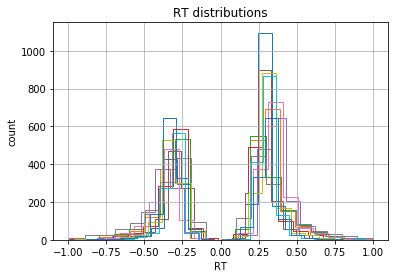

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

In [9]:
conf_df = data[(data.stim=='hc')|( data.stim=='lc')]
conf_df.head()
vol_df = data[(data.stim=='hv')|( data.stim=='lv')]
vol_df.head()

response        rt stim  subj_idx
1800       0.0 -0.738985   hv       770
1801       0.0 -0.697122   hv       770
1802       1.0  0.577064   hv       770
1803       1.0  0.655899   hv       770
1804       1.0  0.365610   hv       770

In [10]:
np.unique(vol_df.stim), np.unique(conf_df.stim)

(array(['hv', 'lv'], dtype=object), array(['hc', 'lc'], dtype=object))

In [11]:
np.unique(vol_df.subj_idx), np.unique(conf_df.subj_idx)

(array([761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771]),
 array([761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771]))

In [12]:
conf_df = conf_df.rename(index=str, columns={"stim": "conf"})
vol_df = vol_df.rename(index=str, columns={"stim": "vol"})

In [13]:
conf_vol_df = pd.concat([conf_df, vol_df])
conf_vol_df['vol_flag'] = conf_vol_df.vol
conf_vol_df['conf_flag'] = conf_vol_df.conf

conf_vol_df.conf_flag=conf_vol_df.conf_flag.fillna('mc')
conf_vol_df.vol_flag=conf_vol_df.vol_flag.fillna('mv')

In [14]:
conf_vol_df = conf_vol_df.drop(['conf','vol'], 1)

In [15]:
conf_vol_df = conf_vol_df.rename(index=str, columns={"vol_flag": "vol", "conf_flag": "conf"})
conf_vol_df.head()

response        rt  subj_idx vol conf
0       1.0  0.525745       770  mv   hc
1       0.0 -0.296897       770  mv   hc
2       0.0 -0.210249       770  mv   hc
3       1.0  0.276397       770  mv   hc
4       1.0  0.287072       770  mv   hc

In [16]:
np.unique(conf_vol_df.conf), np.unique(conf_vol_df.vol)

(array(['hc', 'lc', 'mc'], dtype=object),
 array(['hv', 'lv', 'mv'], dtype=object))

## Within-subjects regression 

#### Treatment specifies intercept (comparison condition) 
#### C(x) specifies categorical predictor 

##### (design matrix will auto-code dummy variables)

#### trialwise response ~ categorical predictor, intercept condition 

In [18]:
formula = "1+C(vol, Treatment('mv'))*C(conf,Treatment('mc'))"
d_mat = dmatrix(formula, conf_vol_df)
print(d_mat.design_info.column_names)
print(d_mat)
sum(d_mat)

['Intercept', "C(vol, Treatment('mv'))[T.hv]", "C(vol, Treatment('mv'))[T.lv]", "C(conf, Treatment('mc'))[T.hc]", "C(conf, Treatment('mc'))[T.lc]", "C(vol, Treatment('mv'))[T.hv]:C(conf, Treatment('mc'))[T.hc]", "C(vol, Treatment('mv'))[T.lv]:C(conf, Treatment('mc'))[T.hc]", "C(vol, Treatment('mv'))[T.hv]:C(conf, Treatment('mc'))[T.lc]", "C(vol, Treatment('mv'))[T.lv]:C(conf, Treatment('mc'))[T.lc]"]
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  1. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  0.  0.]
 [ 1.  0.  1. ...,  0.  0.  0.]]


array([ 26400.,   6600.,   6600.,   6600.,   6600.,      0.,      0.,
            0.,      0.])

In [19]:
d_mat

DesignMatrix with shape (26400, 9)
  Columns:
    ['Intercept',
     "C(vol, Treatment('mv'))[T.hv]",
     "C(vol, Treatment('mv'))[T.lv]",
     "C(conf, Treatment('mc'))[T.hc]",
     "C(conf, Treatment('mc'))[T.lc]",
     "C(vol, Treatment('mv'))[T.hv]:C(conf, Treatment('mc'))[T.hc]",
     "C(vol, Treatment('mv'))[T.lv]:C(conf, Treatment('mc'))[T.hc]",
     "C(vol, Treatment('mv'))[T.hv]:C(conf, Treatment('mc'))[T.lc]",
     "C(vol, Treatment('mv'))[T.lv]:C(conf, Treatment('mc'))[T.lc]"]
  Terms:
    'Intercept' (column 0)
    "C(vol, Treatment('mv'))" (columns 1:3)
    "C(conf, Treatment('mc'))" (columns 3:5)
    "C(vol, Treatment('mv')):C(conf, Treatment('mc'))" (columns 5:9)
  (to view full data, use np.asarray(this_obj))

In [21]:
v_reg_model = "v ~" + formula
a_reg_model = "a ~ " + formula
av_reg_model = [v_reg_model, a_reg_model]

In [ ]:
v_within_subj = hddm.HDDMRegressor(conf_vol_df, v_reg_model)
v_within_subj.sample(5000,burn=200)

Adding these covariates:
['v_Intercept', "v_C(vol, Treatment('mv'))[T.hv]", "v_C(vol, Treatment('mv'))[T.lv]", "v_C(conf, Treatment('mc'))[T.hc]", "v_C(conf, Treatment('mc'))[T.lc]", "v_C(vol, Treatment('mv'))[T.hv]:C(conf, Treatment('mc'))[T.hc]", "v_C(vol, Treatment('mv'))[T.lv]:C(conf, Treatment('mc'))[T.hc]", "v_C(vol, Treatment('mv'))[T.hv]:C(conf, Treatment('mc'))[T.lc]", "v_C(vol, Treatment('mv'))[T.lv]:C(conf, Treatment('mc'))[T.lc]"]


/Users/Krista/anaconda/envs/hddm/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-------          19%                  ] 966 of 5000 complete in 185000.9 sec

In [ ]:
a_within_subj = hddm.HDDMRegressor(conf_vol_df, a_reg_model)
a_within_subj.sample(5000,burn=200)

In [ ]:
av_within_subj = hddm.HDDMRegressor(conf_vol_df, av_reg_model)
av_within_subj.sample(5000,burn=200)

#### extract DIC score

In [ ]:
v_within_subj.dic, a_within_subj.dic, av_within_subj.dic

#### plot within-subjects effects for winning model

In [ ]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30

names = [r'$a + v$',r'$a$',r'$v$']
dics = [v_within_subj.dic,  a_within_subj.dic, av_within_subj.dic]
bars = plt.barh(names,dics, alpha=0.5)
plt.xlabel('DIC score')

bars[0].set_color('r')
bars[1].set_color('blue')
bars[2].set_color('forestgreen')

plt.axvline(av_within_subj.dic, color='k', alpha=0.5, linestyle = '--')

In [ ]:
v_WL, v_LL, v_WW = v_within_subj.nodes_db.ix[["v_Intercept", 
                                              "v_C(stim, Treatment('WL'))[T.LL]", 
                                              "v_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

In [ ]:
a_WL, a_LL, a_WW = a_within_subj.nodes_db.ix[["a_Intercept", 
                                              "a_C(stim, Treatment('WL'))[T.LL]", 
                                              "a_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([a_WL, a_LL, a_WW])
plt.xlabel('bound')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject bound effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

#### extract DIC score

#### all stats

In [ ]:
# v_within_subj.print_stats()